# Benchmarking: predicting retinotopic organization from brain structure

Here we benchmark our approach by comparing our current model performance against two other approches that predict retinotopic organization from brain structure solely. These approaches are deepRetinotopy21 (Ribeiro, Bollmann, Puckett, 2021) and Benson14 (Benson et al., 2014).
We use two metrics for benchmarking: error and correlation coefficient. Error is given by the smallest difference between two angles and is determined as the difference between the predicted and the empirical angle values in a vertex-wise manner and averaged across a given region of interest. Our second metric, correlation, was determined by the Pearson correlation (or circular correlation for polar angle) of empirical and predicted maps within a given region of interest. In sum, we performed the following steps:
1. Apply the anatomical template of retinotopy (Benson et al., 2014) to the HCP dataset;
2. Benchmark models' performance in early visual cortex;
3. Visualize predicted/empirical maps from the test set;


## Import libraries and functions

In [3]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
import astropy.units as u
import numpy as np
import nibabel as nib
import os.path as osp

sys.path.append('./../')

from functions.evaluation import *
from functions.datasets import *
from astropy.stats import circcorrcoef
from ipywidgets import interact, Dropdown

## 1. Apply an anatomical template of retinotopy (Benson et al., 2014) to the HCP dataset

First, we need to run neuropythy on the HCP dataset to estimate retinotopic maps from brain structure using benson14_retinotopy model. To do it, we need to first set up the ~/.npythyrc configuration file (see [documentation](https://github.com/noahbenson/neuropythy)) with appropriate paths:

```
{"freesurfer_subject_paths": "/PATH_TO_FREESURFER_DATA",
 "data_cache_root":          "~/tmp/npythy_cache",
 "hcp_subject_paths":        "",
 "hcp_auto_download":        true,
 "hcp_credentials":          ""}
```

Additionally, make sure each subject folder contain all freesurfer dirs, i.e., 

```
.
├── label
├── mri
├── scripts
├── stats
├── surf
└── touch
```

Then we can run the following bash scrip that will perform all the required steps. But, before running the cell below, make sure you activate an environment with neuropythy available.

In [2]:
%%bash
ml connectomeworkbench/1.5.0
ml freesurfer/7.3.2

cd ../HCP/freesurfer
for sub in *; do
    cd $sub
    # 1. Download required nifti files
    # aws s3 cp s3://hcp-openaccess/HCP_1200/$sub/T1w/$sub/mri/brain.mgz ./mri/brain.mgz 
    # aws s3 cp s3://hcp-openaccess/HCP_1200/$sub/T1w/$sub/mri/ribbon.mgz ./mri/ribbon.mgz 
    # 2. Estimate retinotopic maps with benson14 model
    python -m neuropythy benson14_retinotopy $sub --no-volume-export -v --surf-format=mgz
    # 3. Convert retinotopic maps to gifti
    for hemisphere in lh rh; do
        for metric in angle eccen sigma varea; do
            mris_convert -c ./surf/"$hemisphere".benson14_"$metric".mgz ./surf/"$hemisphere".white \
                        ./surf/"$hemisphere".benson14_"$metric".gii
        done
    done
    # 4. Convert polar angle maps
    for hemisphere in lh rh; do
        # Convert to 0-360 range
        python -c "import sys; sys.path.append('/home/ribeiro/Projects/deepRetinotopy_validation/'); from functions.preprocess import transform_polarangle_benson14; transform_polarangle_benson14('./surf/"$hemisphere".benson14_angle.gii', '"$hemisphere"')"
    done                  
    cd ..
done


# 5. Register data from native space to 32k_fs_LR space
for sub in *; do
    for hemisphere in lh rh; do
        if [ $hemisphere == "lh" ]; then
            hemi="L"
        else
            hemi="R"
        fi
        for metric in angle eccen sigma; do
            if [ $metric == "angle" ]; then
                metric_new="polarAngle"
            elif [ $metric == "eccen" ]; then
                metric_new="eccentricity"
            elif [ $metric == "sigma" ]; then
                metric_new="pRFsize"
            fi
            if [ $metric == "angle" ] && [ $hemisphere == "lh" ]; then
                python -c "import sys; sys.path.append('/home/ribeiro/Projects/deepRetinotopy_validation/'); \
                                    from functions.preprocess import transform_angle; \
                                    transform_angle('"$sub"/surf/lh.benson14_angle_neuropythy.gii', '"$hemisphere"')"

                wb_command -metric-resample "$sub"/surf/"$hemisphere".benson14_angle_neuropythy_transformed.gii \
                "$sub"/surf/"$hemisphere".sphere.reg.surf.gii /home/ribeiro/Projects/deepRetinotopy_validation/templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                ADAP_BARY_AREA $sub/surf/"$hemisphere".benson14_"$metric_new".func.gii \
                -area-surfs $sub/surf/"$hemisphere".midthickness.surf.gii $sub/surf/"$sub"."$hemisphere".midthickness.32k_fs_LR.surf.gii         
            elif [ $metric == "angle" ] && [ $hemisphere == "rh" ]; then
                wb_command -metric-resample "$sub"/surf/"$hemisphere".benson14_angle_neuropythy.gii \
                "$sub"/surf/"$hemisphere".sphere.reg.surf.gii /home/ribeiro/Projects/deepRetinotopy_validation/templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                ADAP_BARY_AREA $sub/surf/"$hemisphere".benson14_"$metric_new".func.gii \
                -area-surfs $sub/surf/"$hemisphere".midthickness.surf.gii $sub/surf/"$sub"."$hemisphere".midthickness.32k_fs_LR.surf.gii
            else
                wb_command -metric-resample "$sub"/surf/"$hemisphere".benson14_"$metric".gii \
                "$sub"/surf/"$hemisphere".sphere.reg.surf.gii /home/ribeiro/Projects/deepRetinotopy_validation/templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                ADAP_BARY_AREA $sub/surf/"$hemisphere".benson14_"$metric_new".func.gii \
                -area-surfs $sub/surf/"$hemisphere".midthickness.surf.gii $sub/surf/"$sub"."$hemisphere".midthickness.32k_fs_LR.surf.gii         
            fi
        done
    done
done

Processing subject 100610:
   - Interpolating template...
   - Exporting surfaces:
    - Exporting LH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/lh.benson14_eccen.mgz
    - Exporting LH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/lh.benson14_sigma.mgz
    - Exporting LH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/lh.benson14_varea.mgz
    - Exporting LH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/lh.benson14_angle.mgz
    - Exporting RH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/rh.benson14_eccen.mgz
    - Exporting RH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/rh.benson14_sigma.mgz
    - Exporting RH prediction file: /home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/100610/surf/r

## 2. Benchmarking models' performance across early visual areas for both hemispheres

Here we have the code for generating the plots shown in Figure 2.

In [39]:
# Function for benchmarking models across early visual areas

from deepRetinotopy_TheToolbox.utils.rois import ROIs_WangParcels as roi_parcel

def calculate_performance(retinotopic_map, map_1, map_2, model, metric = 'correlation'):

    from scipy import stats
    from astropy.stats import circcorrcoef
    if metric == 'correlation':
        if retinotopic_map == 'polarAngle':
            theta = circcorrcoef(map_1, map_2)
            if model == 'noise_ceiling':
                theta = (2 * theta) / (1 + (2 - 1) * theta)
        elif retinotopic_map == 'pRFsize' or retinotopic_map == 'eccentricity':
            theta = stats.pearsonr(map_1, map_2)[0]
            if model == 'noise_ceiling':
                theta = (2 * theta) / (1 + (2 - 1) * theta) # Spearman-Brown correction
    elif metric == 'error':
        if retinotopic_map == 'polarAngle':
            theta = smallest_angle(map_1, map_2)
        elif retinotopic_map == 'pRFsize' or retinotopic_map == 'eccentricity':
            theta = np.abs(map_1 - map_2)
    return theta
        

def benchmark_models(path, retinotopic_map, hemisphere, threshold = 10, 
                     list_of_models = ['deepRetinotopy25', 'deepRetinotopy21','benson14'], 
                     region_of_interest = 'earlyVisualCortex', include_individual_variability = False, metric = 'correlation'):
    """Calculate the inter-individual variability in predicted maps and the error
    between predicted and empirical maps for different models.
    
    Args:
        path (str): Path to the Freesurfer directory 
        retinotopic_map (str): Type of retinotopic map ('polarAngle', 'eccentricity' or 'pRFsize')
        hemisphere (str): Hemisphere ('lh' or 'rh')
        threshold (float): Threshold for the explained variance (default is 10). Explained variance from HCP data ranges from 0 to 100.
        list_of_models (list): List of models to benchmark. 
            Default is ['deepRetinotopy25', 'deepRetinotopy21','benson14'].
        region_of_interest (str): Region of interest to benchmark.
            Default is 'earlyVisualCortex'.
        include_individual_variability (bool): If True, include inter-individual variability in predicted maps.
            Default is False.
        metric (str): Metric to use for benchmarking.
            Default is 'correlation'. Options are 'correlation' or 'error'.
    Returns:
        df (pandas dataframe): Dataframe containing the inter-individual variability in predicted maps 
            and the error.
        plt (matplotlib.pyplot): Plot of the inter-individual variability in predicted maps and the error. 
            PNG file saved at the output folder.
    """
    from functions.evaluation import create_mask
    
    # Initialize lists to store results
    mean_ind_variability = []
    error = []
    # Test dataset from HCP
    test_set = ['680957', '191841', '617748', '725751', '198653',
                         '191336', '572045', '601127', '644246', '157336']

    # Region of interest 
    ## Region of interest used for training
    final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
    ## Early visual cortex
    print('Region of interest: ' + region_of_interest)
    if region_of_interest == 'earlyVisualCortex':
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])
    elif region_of_interest != 'earlyvisualcortex':
        if region_of_interest == 'V1':
            areas = ['V1v', 'V1d']
        elif region_of_interest == 'V2':
            areas = ['V2v', 'V2d']
        elif region_of_interest == 'V3':
            areas = ['V3v', 'V3d']
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_parcel(areas)
    
    ROI_masked, mask = create_mask(final_mask_L_ROI, final_mask_R_ROI, final_mask_L, final_mask_R, hemisphere)
    mask = mask[ROI_masked == 1]

    for model in list_of_models:
        theta_withinsubj = []
        theta_acrosssubj_pred = []
        for j in range(len(test_set)):
            theta_pred_across_temp = []
            for i in range(len(test_set)):
                # Error
                if i == j:
                    # Loading maps
                    data = RetinotopyData(path, test_set[i], hemisphere, retinotopic_map, model = model, split_half=True)
                    data.apply_mask_to_maps(ROI_masked)
                    data.apply_mask_to_maps(mask)

                    # Transform polar angle values
                    if retinotopic_map == 'polarAngle':
                        if hemisphere == 'lh':
                            data.apply_transform_polarangle()
                        data.convert_to_radian()

                    # Apply threshold mask
                    if threshold != None:
                        mask_threshold = data.variance_explained > threshold
                        data.apply_mask_to_maps(mask_threshold)

                    # Calculate performance or noise ceiling/error floor    
                    if model == 'noise_ceiling':
                        theta = calculate_performance(retinotopic_map, data.empirical_map_split2, data.empirical_map_split3, model, metric)
                    else:
                        theta = calculate_performance(retinotopic_map, data.predicted_map, data.empirical_map, model, metric)

                    # Append results
                    if metric == 'error':
                        theta_withinsubj.append(np.mean(theta))
                    elif metric == 'correlation':
                        theta_withinsubj.append(theta)

                # Inter-individual variability in predicted maps
                if include_individual_variability:
                    if i != j:
                        # Loading maps
                        data_1 = RetinotopyData(path, test_set[i], hemisphere, retinotopic_map, model=model)
                        data_1.apply_mask_to_maps(ROI_masked)
                        data_1.apply_mask_to_maps(mask)

                        data_2 = RetinotopyData(path, test_set[j], hemisphere, retinotopic_map, model=model)
                        data_2.apply_mask_to_maps(ROI_masked)
                        data_2.apply_mask_to_maps(mask)

                        # Transform polar angle values
                        if retinotopic_map == 'polarAngle':
                            if hemisphere == 'lh':
                                data_1.apply_transform_polarangle()
                                data_2.apply_transform_polarangle()
                            data_1.convert_to_radian()
                            data_2.convert_to_radian()

                        # Calculating inter-individual variability
                        theta_pred = calculate_performance(retinotopic_map, data_1.predicted_map, data_2.predicted_map, model, metric)
                        if metric == 'error':
                            theta_pred_across_temp.append(np.mean(theta_pred))
                        elif metric == 'correlation':
                            theta_pred_across_temp.append(theta_pred)
                    theta_acrosssubj_pred.append(theta_pred_across_temp)
                else:
                    continue              
            
        mean_theta_withinsubj = np.array(theta_withinsubj)
        error.append(mean_theta_withinsubj)
        if include_individual_variability:
            mean_theta_acrosssubj_pred = np.median(np.array(theta_acrosssubj_pred), axis=1)
            mean_ind_variability.append(mean_theta_acrosssubj_pred)

    error = np.reshape(np.array(error), (len(list_of_models), -1))
    
    # Create dataframe
    if metric == 'correlation':
        model_names = {'deepRetinotopy25': 'Ours (2025)',
                    'deepRetinotopy21': 'Ribeiro et al. (2021)',
                    'benson14': 'Benson et al. (2014)',
                    'noise_ceiling': 'Noise ceiling'}
        names_models = [model_names[model] for model in list_of_models]
    elif metric == 'error':
        model_names = {'deepRetinotopy25': 'Ours (2025)',
                    'deepRetinotopy21': 'Ribeiro et al. (2021)',
                    'benson14': 'Benson et al. (2014)',
                    'noise_ceiling': 'Error floor'}
        names_models = [model_names[model] for model in list_of_models]
    data_error = [[error[i], 
                    len(error[i]) * [names_models[i]],
                    len(error[i]) * ['Error']] for i in range(len(list_of_models))]
    if include_individual_variability:
        mean_ind_variability = np.reshape(np.array(mean_ind_variability), (len(list_of_models), -1))
        data_ind_variability = [[mean_ind_variability[i], 
                                len(mean_ind_variability[i]) * [names_models[i]],
                                len(mean_ind_variability[i]) * ['Individual variability']] for i in range(len(list_of_models))]
        data = np.concatenate(data_error + data_ind_variability, axis = 1)
    else:
        data = np.concatenate(data_error, axis = 1)
    df = pd.DataFrame(columns=['Estimated value', 'Model', 'Metric'],
                      data=data.T)
    df['Estimated value'] = df['Estimated value'].astype(float)

    # Generate plot     
    sns.set_style("white")
    fig = plt.figure()
    plt.xlim(-0.5, 0.5)
    if retinotopic_map == 'polarAngle':
        # palette_1 = ['#340f5aff','#7769a3ff','#bfbcd8ff', '#999999ff']
        palette_1 = ['#402661ff','#895dc0ff','#bea6ddff', '#999999ff']
    elif retinotopic_map == 'eccentricity':
        # palette_1 = ['#bb702bff','#e7a658ff','#f8ddb2ff', '#999999ff']
        palette_1 = ['#a65e12ff','#e99235ff','#f3c491ff', '#999999ff']
    else: 
        # palette_1 = ["#35556eff",'#90afcaff','#afc6d8ff', '#999999ff']
        palette_1 = ["#348cb7ff",'#78b9d9ff','#c8e3efff', '#999999ff']

    # Remove noise ceiling or error floor from dataframe so it is used as gray shaded area
    if metric == 'correlation':
        ceiling_data = df[df['Model']=='Noise ceiling']['Estimated value']
        df.drop(index=df[df['Model']=='Noise ceiling'].index, inplace=True)
    elif metric == 'error':
        ceiling_data = df[df['Model']=='Error floor']['Estimated value']
        df.drop(index=df[df['Model']=='Error floor'].index, inplace=True)

    ax = sns.barplot(data=df, y='Estimated value', x="Metric", hue='Model',
                    palette=sns.color_palette(palette_1, desat=1.0), dodge=0.5, errorbar=('ci', 95))
    ax = sns.swarmplot(data=df, y='Estimated value', x="Metric", hue='Model',
                    color='gray_r', dodge=0.5, alpha=.7, legend=False)
    
    # Create shaded area for noise ceiling or error floor
    if metric == 'error':
        mean_val = np.mean(ceiling_data)
        std_val = np.std(ceiling_data)
        # plt.hlines(mean_val, -0.5, .5, color='black', linewidth=1, linestyles='--')
        plt.fill_between([-0.5, .5], mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray')
        # plt.hlines(np.mean(df[df['Model']=='Error floor']['Estimated value']), -0.5, .5, color='black', linewidth=1, linestyles='--')
    elif metric == 'correlation':
        mean_val = np.mean(ceiling_data)
        std_val = np.std(ceiling_data)
        print(mean_val)
        # plt.hlines(mean_val, -0.5, .5, color='black', linewidth=1, linestyles='--')
        plt.fill_between([-0.5, .5], mean_val - std_val, mean_val + std_val, alpha=0.2, color='gray')
        # plt.hlines(np.mean(df[df['Model']=='Noise ceiling']['Estimated value']), -0.5, .5, color='black', linewidth=1, linestyles='--')
    plt.xlabel('Model', fontsize=17)
    ax.set_xticklabels('')

    # Plot title configuration and y-axis label
    if metric == 'correlation':
        plt.ylabel('Correlation', fontsize=17)
        plt.ylim(0, 1)
        if retinotopic_map == 'polarAngle':
            map_title = 'Polar Angle'
        elif retinotopic_map == 'eccentricity':
            map_title = 'Eccentricity'
        elif retinotopic_map == 'pRFsize':
            map_title = 'pRF size'
    elif metric == 'error':
        plt.ylabel('$\Delta$$\t\Theta$ (degrees)', fontsize=17)
        if retinotopic_map == 'polarAngle':
            map_title = 'Polar Angle'
            plt.ylim(0, 50)
        elif retinotopic_map == 'eccentricity':
            map_title = 'Eccentricity'
            plt.ylim(0, 3)
        elif retinotopic_map == 'pRFsize':
            map_title = 'pRF size'
            plt.ylim(0, 3)

    if hemisphere == 'lh':
        hemisphere_title = '(LH)'
    elif hemisphere == 'rh':
        hemisphere_title = '(RH)'

    if region_of_interest == 'earlyVisualCortex':
        region_of_interest_title = 'Early Visual Cortex'
        fig.suptitle(region_of_interest_title + ' - ' + map_title + ' ' + hemisphere_title, fontsize=18)   
    else:
        fig.suptitle(region_of_interest + ' - ' + map_title + ' ' + hemisphere_title, fontsize=18)
    
    # Create output directory if it does not exist
    if os.path.isdir('../output/benchmarking/') == False:
        os.makedirs('../output/benchmarking/')
    
    # Save plot
    plt.savefig(f"../output/benchmarking/Benchmarking_{region_of_interest}_{retinotopic_map}_{hemisphere}_{metric}.pdf")
    plt.show()
    return df

Benchmarking polarAngle in lh for earlyVisualCortex with metric correlation
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9882973000286618


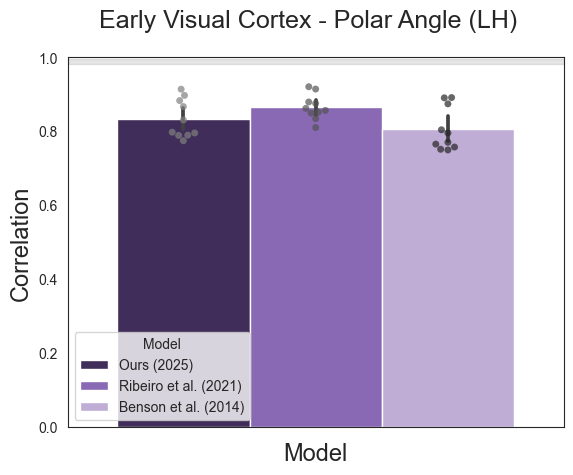

Benchmarking polarAngle in rh for earlyVisualCortex with metric correlation
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9916618365430295


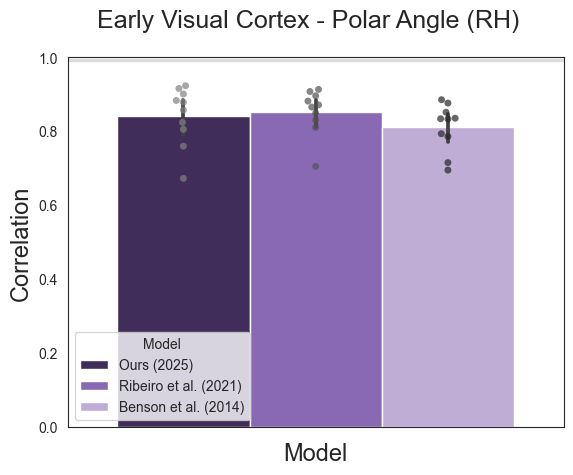

Benchmarking polarAngle in lh for earlyVisualCortex with metric error
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


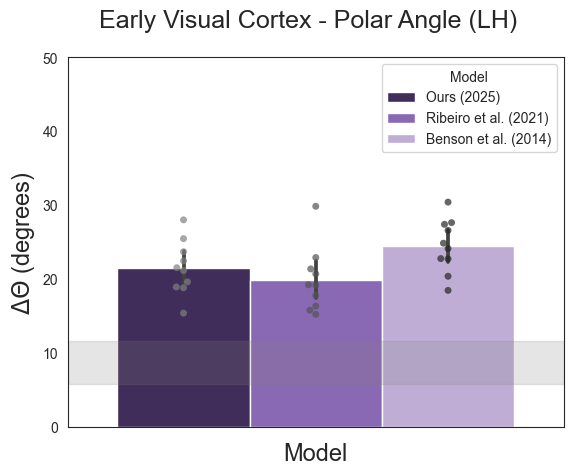

Benchmarking polarAngle in rh for earlyVisualCortex with metric error
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


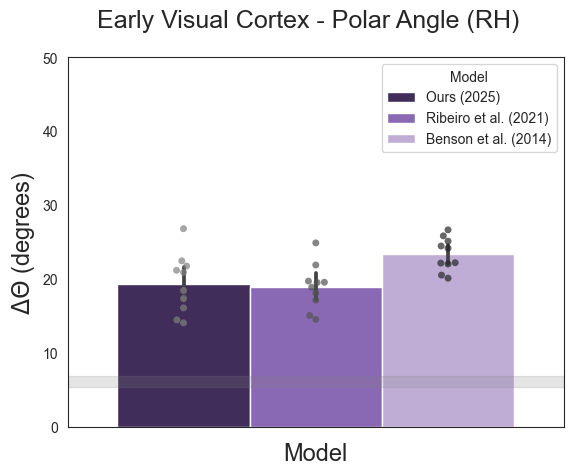

Benchmarking polarAngle in lh for V1 with metric correlation
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.991469745754846


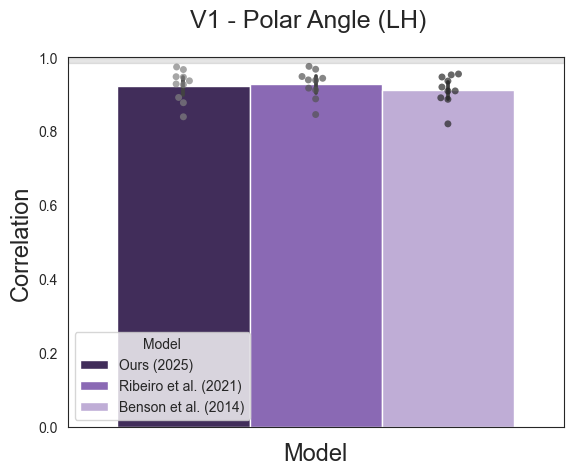

Benchmarking polarAngle in rh for V1 with metric correlation
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9944552667000706


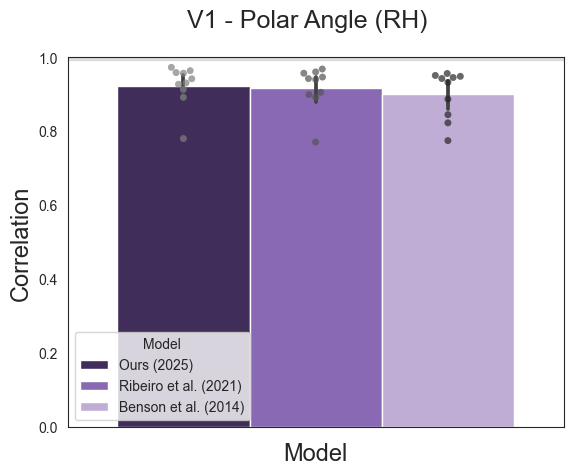

Benchmarking polarAngle in lh for V1 with metric error
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


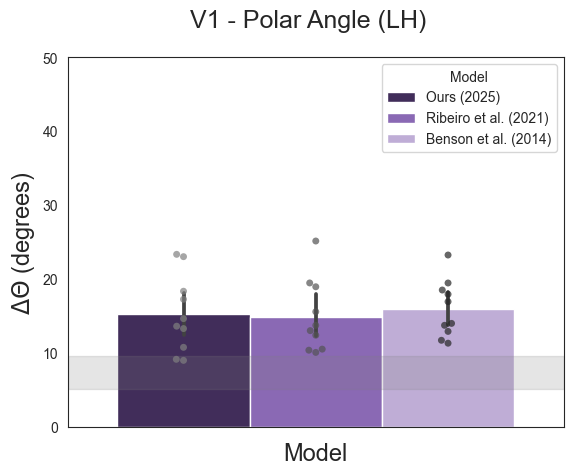

Benchmarking polarAngle in rh for V1 with metric error
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


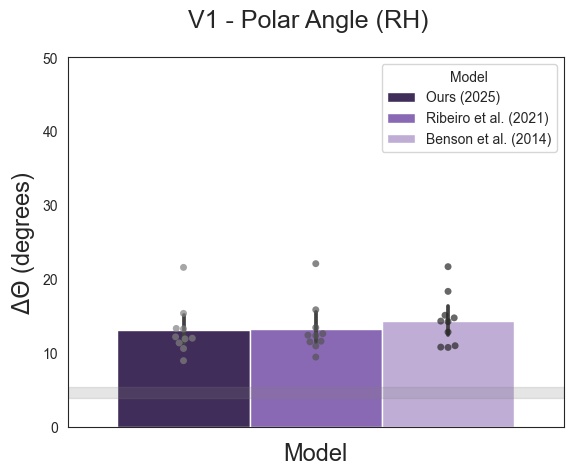

Benchmarking polarAngle in lh for V2 with metric correlation
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9961932212838205


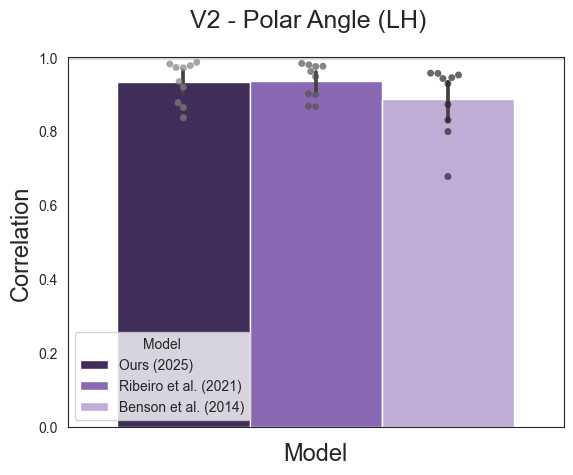

Benchmarking polarAngle in rh for V2 with metric correlation
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9948333871752549


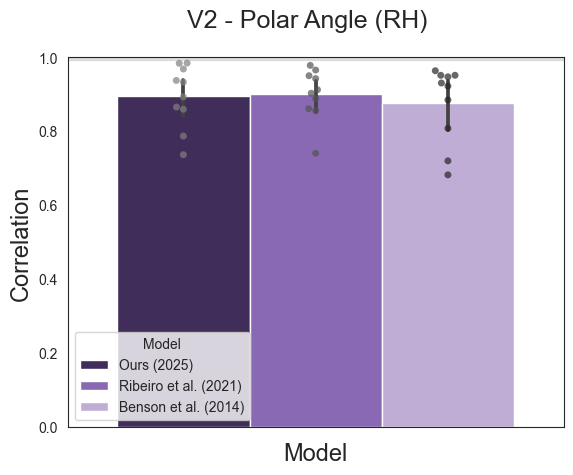

Benchmarking polarAngle in lh for V2 with metric error
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


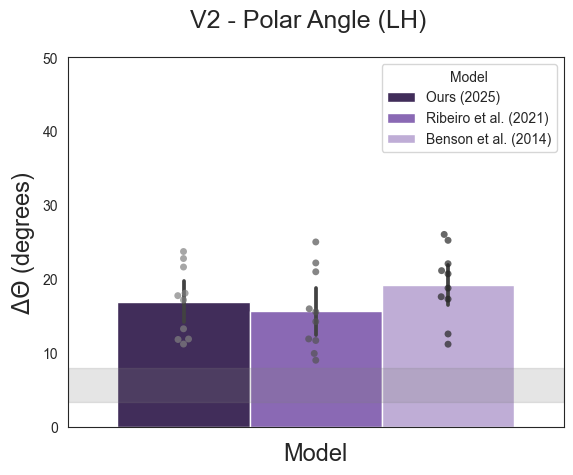

Benchmarking polarAngle in rh for V2 with metric error
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


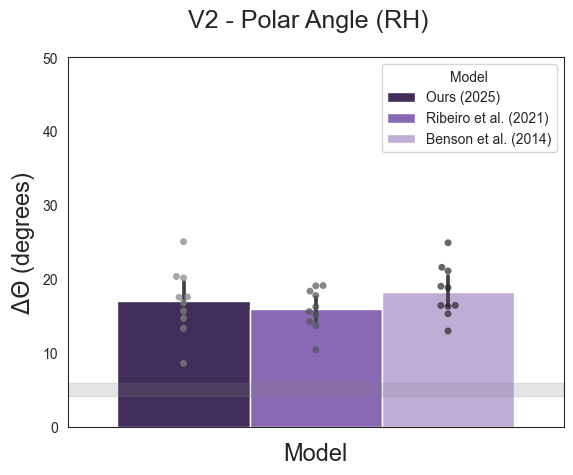

Benchmarking polarAngle in lh for V3 with metric correlation
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9920681399737635


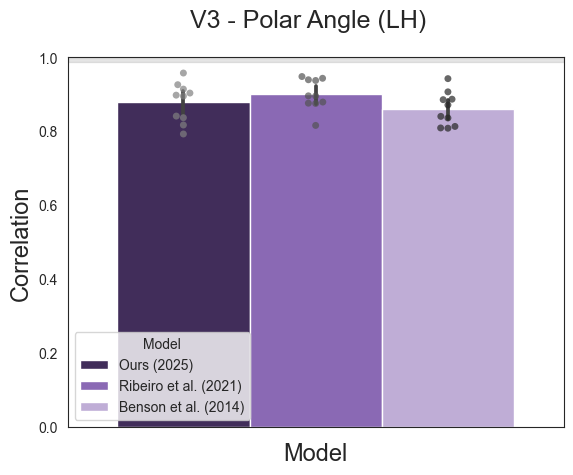

Benchmarking polarAngle in rh for V3 with metric correlation
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9933794942069871


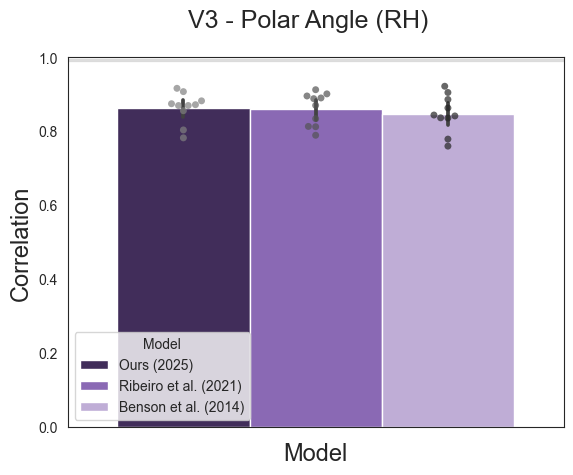

Benchmarking polarAngle in lh for V3 with metric error
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


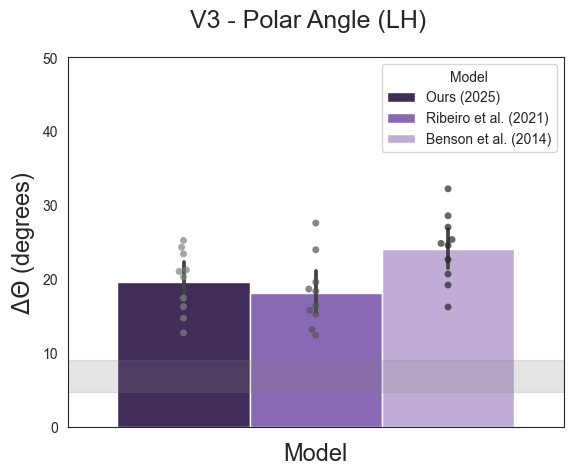

Benchmarking polarAngle in rh for V3 with metric error
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


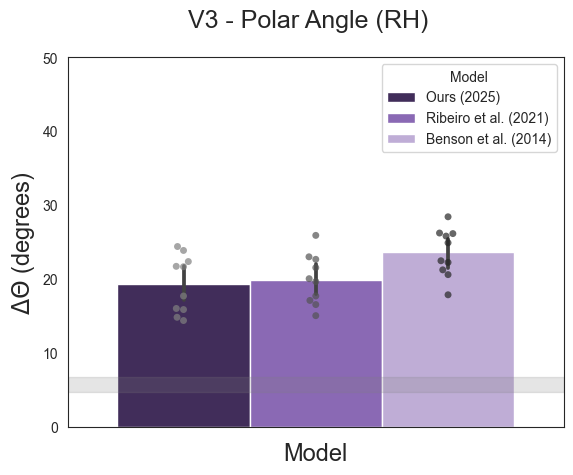

Benchmarking eccentricity in lh for earlyVisualCortex with metric correlation
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9354713158256527


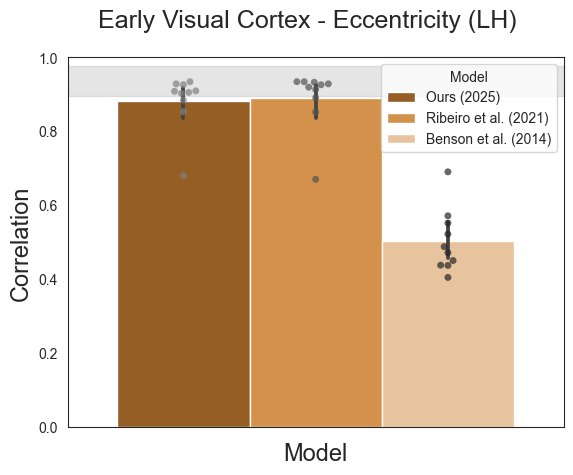

Benchmarking eccentricity in rh for earlyVisualCortex with metric correlation
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9452507076593637


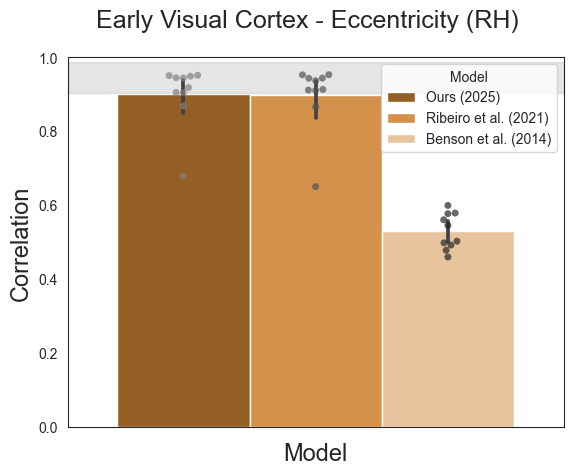

Benchmarking eccentricity in lh for earlyVisualCortex with metric error
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


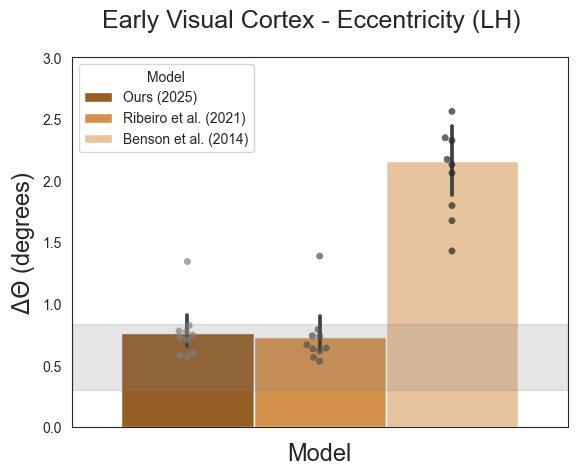

Benchmarking eccentricity in rh for earlyVisualCortex with metric error
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


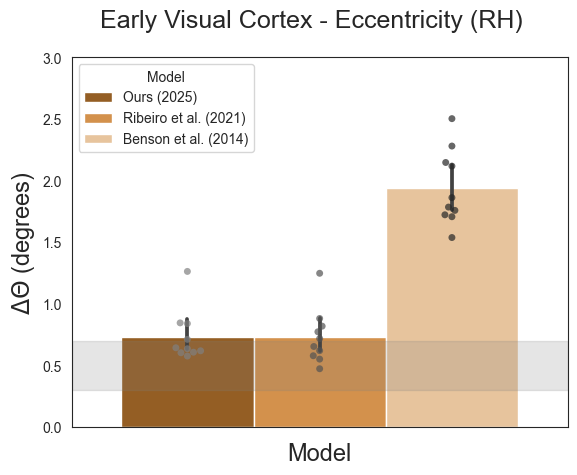

Benchmarking eccentricity in lh for V1 with metric correlation
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9607462449655406


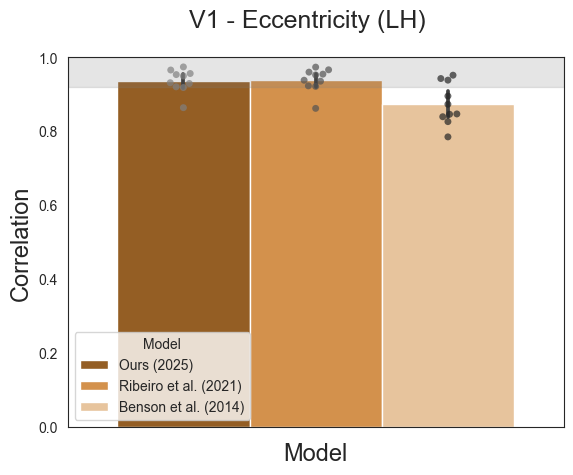

Benchmarking eccentricity in rh for V1 with metric correlation
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9687656552495154


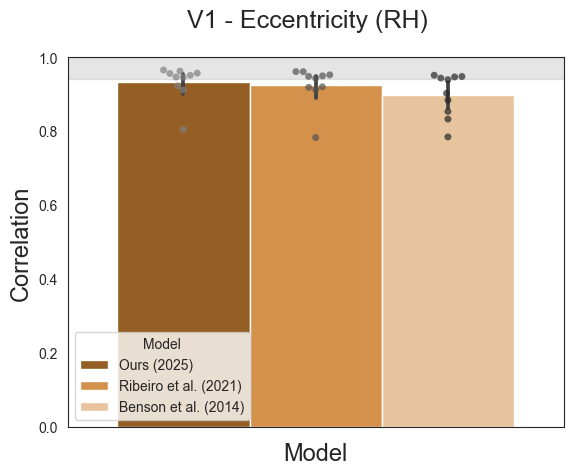

Benchmarking eccentricity in lh for V1 with metric error
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


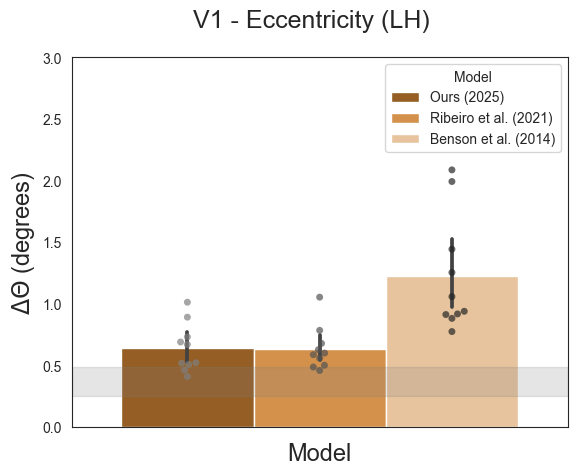

Benchmarking eccentricity in rh for V1 with metric error
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


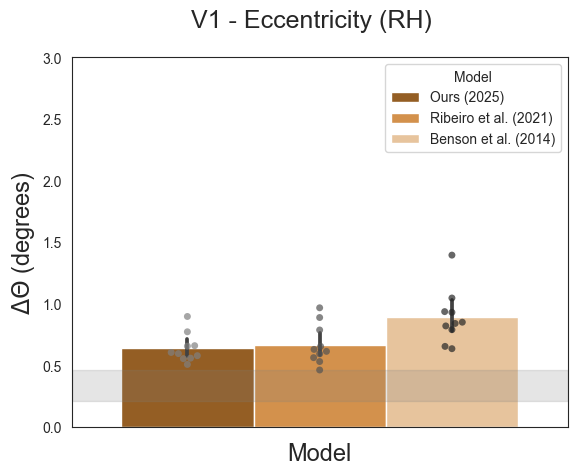

Benchmarking eccentricity in lh for V2 with metric correlation
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9577903075638903


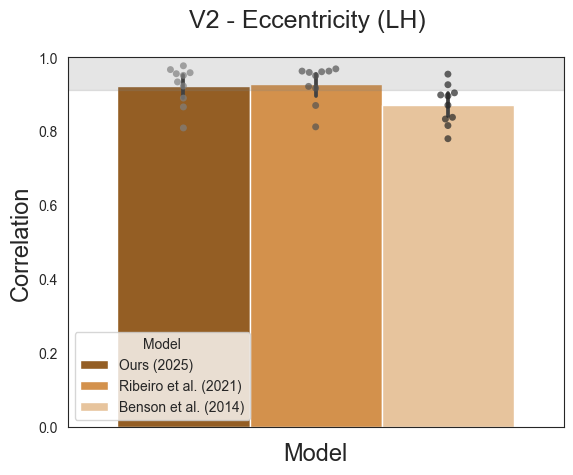

Benchmarking eccentricity in rh for V2 with metric correlation
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9728252415949186


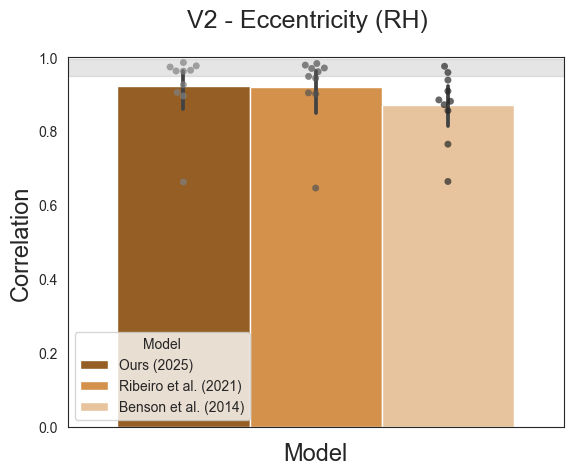

Benchmarking eccentricity in lh for V2 with metric error
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


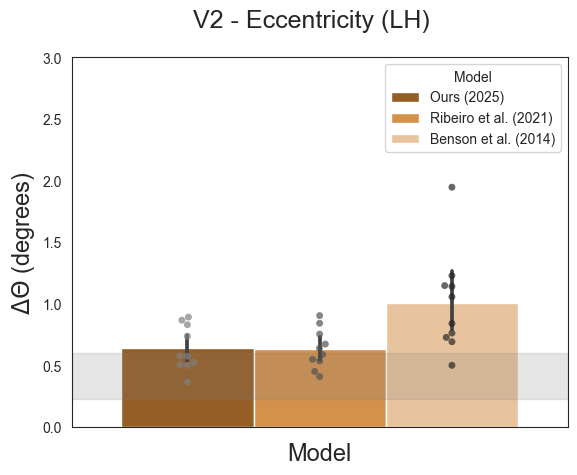

Benchmarking eccentricity in rh for V2 with metric error
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


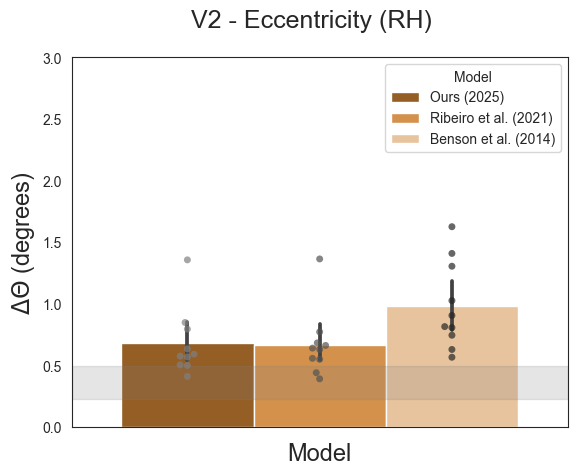

Benchmarking eccentricity in lh for V3 with metric correlation
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9312456117694319


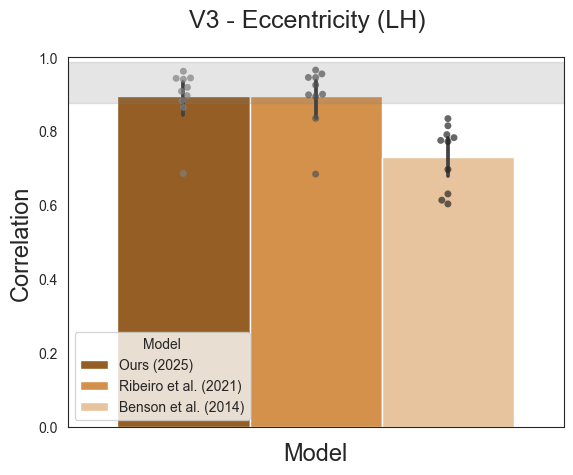

Benchmarking eccentricity in rh for V3 with metric correlation
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.9437229185222238


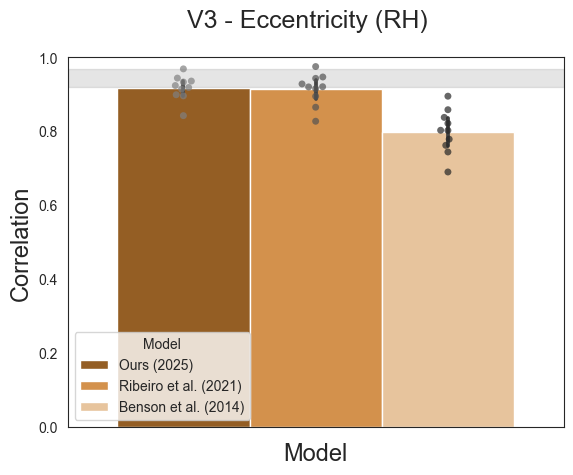

Benchmarking eccentricity in lh for V3 with metric error
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


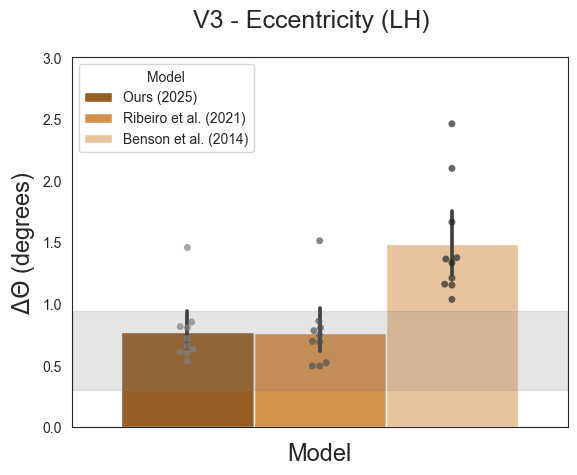

Benchmarking eccentricity in rh for V3 with metric error
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


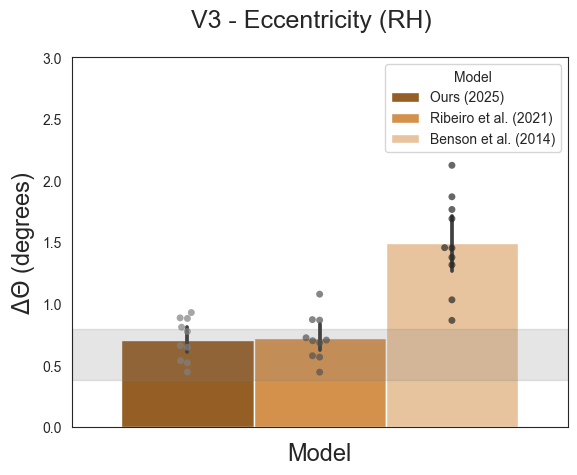

Benchmarking pRFsize in lh for earlyVisualCortex with metric correlation
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.8064550414271311


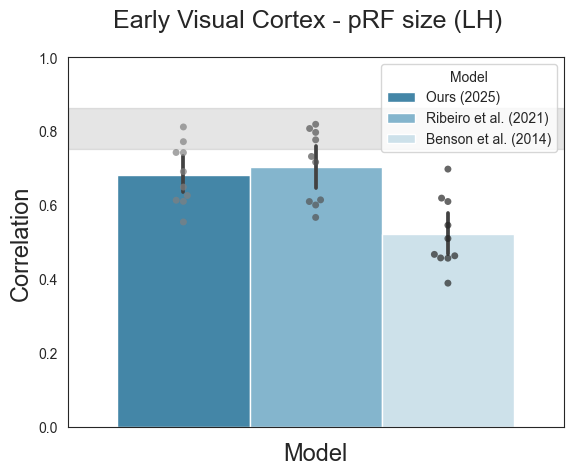

Benchmarking pRFsize in rh for earlyVisualCortex with metric correlation
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.8289609211665245


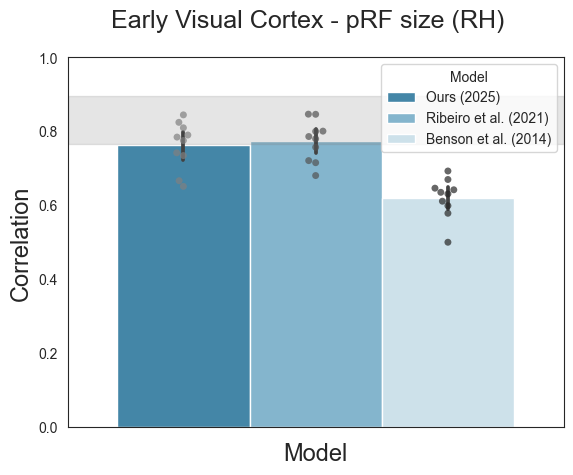

Benchmarking pRFsize in lh for earlyVisualCortex with metric error
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


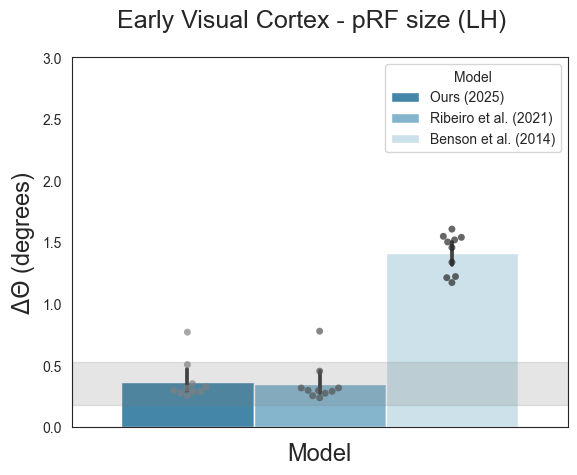

Benchmarking pRFsize in rh for earlyVisualCortex with metric error
Region of interest: earlyVisualCortex


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


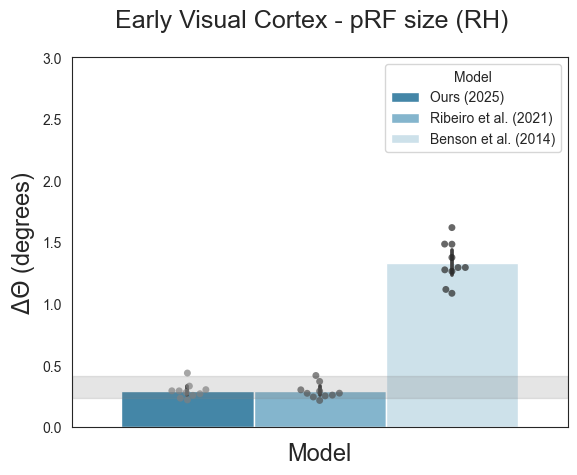

Benchmarking pRFsize in lh for V1 with metric correlation
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.6476249873486893


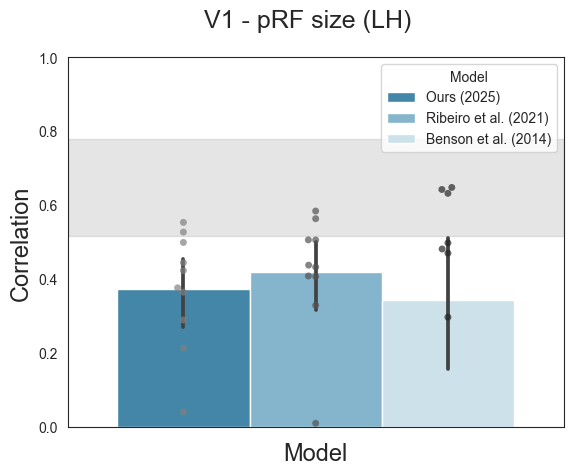

Benchmarking pRFsize in rh for V1 with metric correlation
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.6263039802480711


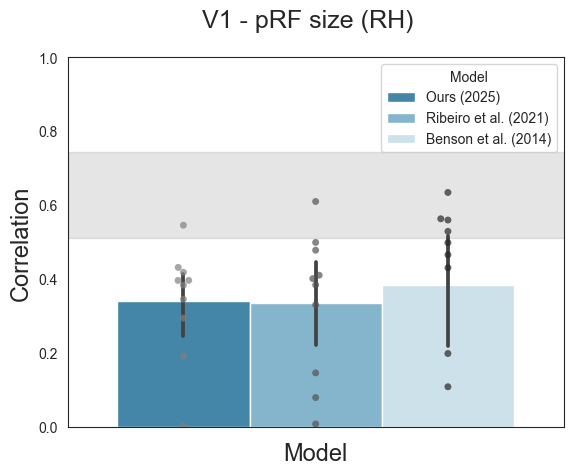

Benchmarking pRFsize in lh for V1 with metric error
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


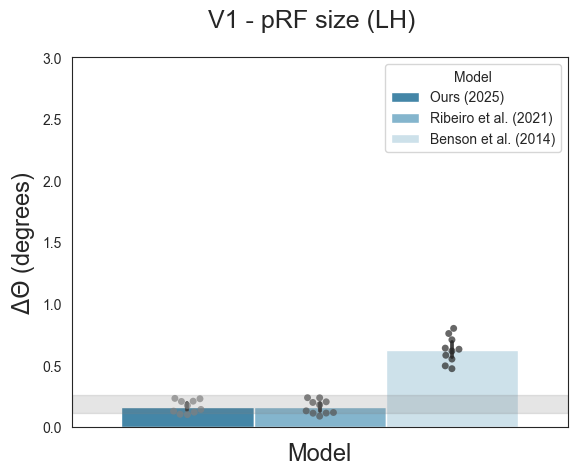

Benchmarking pRFsize in rh for V1 with metric error
Region of interest: V1


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


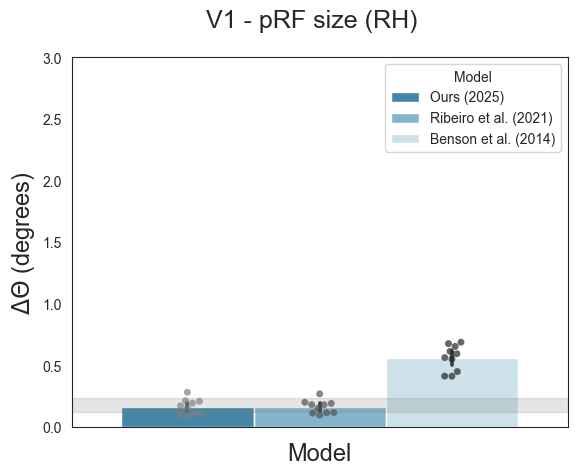

Benchmarking pRFsize in lh for V2 with metric correlation
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.7167668846919822


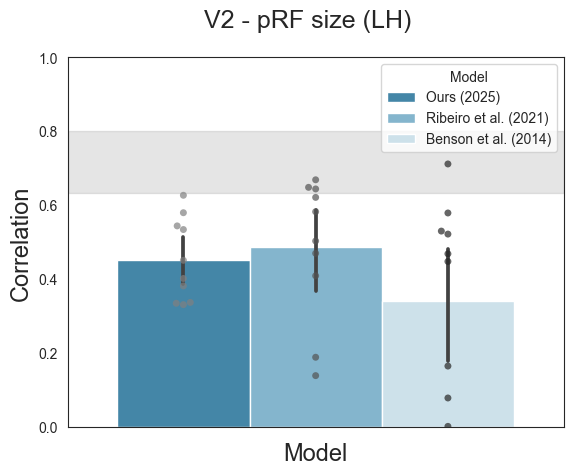

Benchmarking pRFsize in rh for V2 with metric correlation
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.6721637678445035


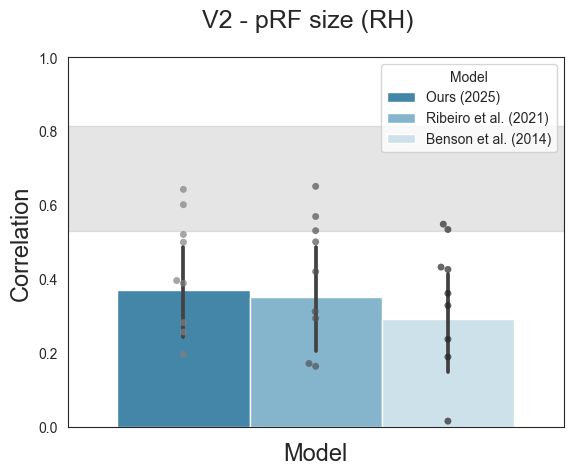

Benchmarking pRFsize in lh for V2 with metric error
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


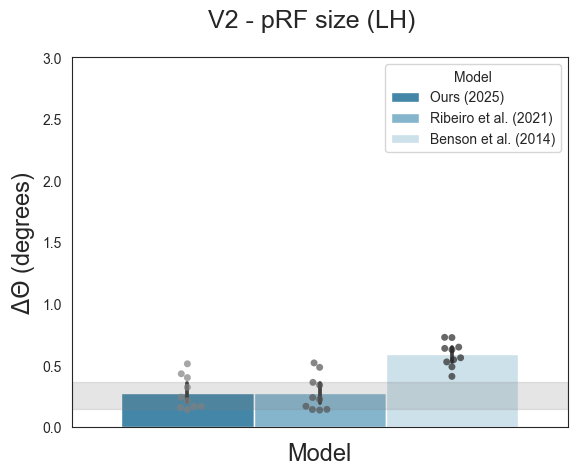

Benchmarking pRFsize in rh for V2 with metric error
Region of interest: V2


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


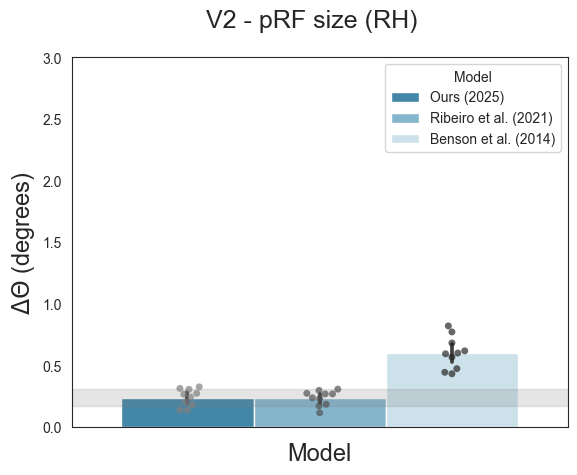

Benchmarking pRFsize in lh for V3 with metric correlation
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.726219398977505


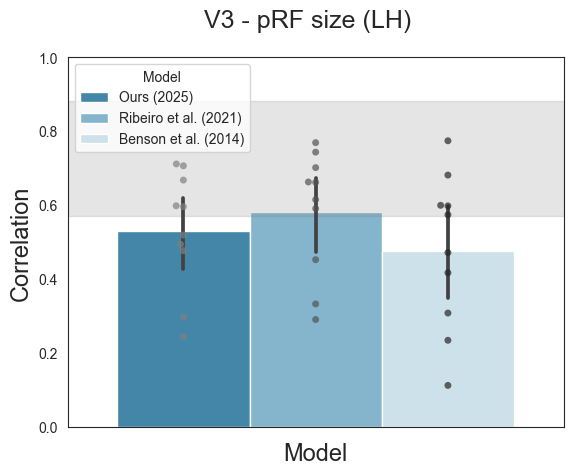

Benchmarking pRFsize in rh for V3 with metric correlation
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


0.7218091790211445


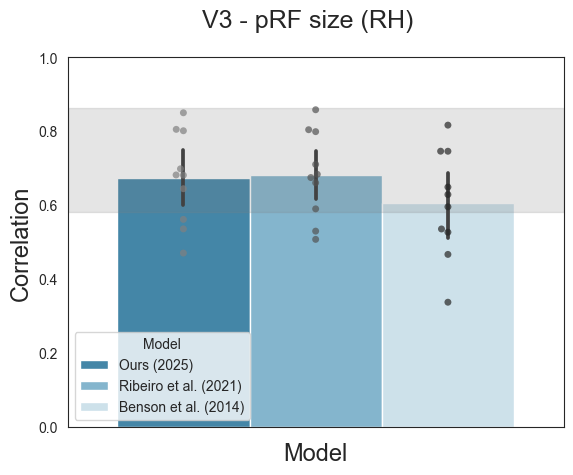

Benchmarking pRFsize in lh for V3 with metric error
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


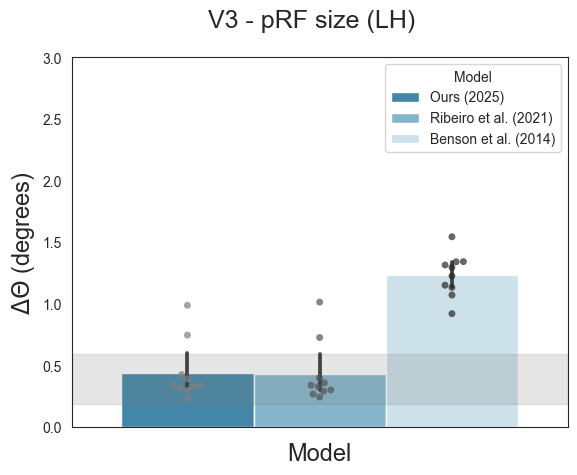

Benchmarking pRFsize in rh for V3 with metric error
Region of interest: V3


/home/ribeiro/miniforge3/envs/deepretinotopy_validation_2/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray_r'` for same effect.
  warnings.warn(msg, FutureWarning)


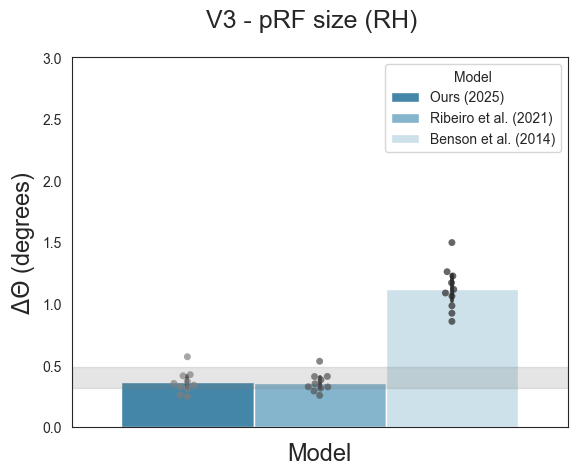

In [40]:
for retinotopic_map in ['polarAngle', 'eccentricity', 'pRFsize']:
    for region_of_interest in ['earlyVisualCortex', 'V1', 'V2', 'V3']:
        for metric in ['correlation', 'error']:
            for hemisphere in ['lh', 'rh']:
                print(f"Benchmarking {retinotopic_map} in {hemisphere} for {region_of_interest} with metric {metric}")
                data_frame = benchmark_models('/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/', 
                                retinotopic_map, hemisphere, 
                                threshold = 10, 
                                list_of_models = ['deepRetinotopy25', 'deepRetinotopy21','benson14', 'noise_ceiling'],
                                region_of_interest=region_of_interest,
                                metric=metric)
                # Save the dataframe to a CSV file
                output_dir = '../output/benchmarking/'
                data_frame.to_csv(f"{output_dir}Benchmarking_{region_of_interest}_{retinotopic_map}_{hemisphere}_{metric}.csv", index=False)

## 3. Visualizing topographic maps

In [ ]:
path_to_freesurfer = '../HCP/freesurfer/'
test_set = ['680957', '191841', '617748', '725751', '198653',
                         '191336', '572045', '601127', '644246', '157336']

prediction = Dropdown(options = ['empirical',
                                 'deepRetinotopy25',
                                 'deepRetinotopy21',
                                 'benson14'])
retinotopic_map = ['polarAngle', 'eccentricity', 'pRFsize']
binarize = Dropdown(options = [False, True])
hemisphere = Dropdown(options = ['lh', 'rh'])

@interact(subject_id=test_set, prediction = prediction, 
          binarize = binarize, retinotopic_map = retinotopic_map,
          hemisphere = hemisphere)
def plot1(subject_id,prediction, binarize, retinotopic_map, hemisphere):
    if prediction == 'empirical':
        retmap = RetinotopyData(path_to_freesurfer, subject_id, hemisphere, retinotopic_map)
        plot_map = 'empirical'
    else:
        retmap = RetinotopyData(path_to_freesurfer, subject_id, hemisphere, retinotopic_map, model=prediction)
        plot_map = 'predicted'
    return retmap.plot_maps(plot_type = plot_map, surface_template_path = '/home/ribeiro/Projects/deepRetinotopy_validation/templates', 
                region_of_interest='earlyvisualcortex', save_html=True)


interactive(children=(Dropdown(description='subject_id', options=('680957', '191841', '617748', '725751', '198…